# Capstone

## Final Project Submission

* Student name: Abigail Campbell
* Student pace: Flex
* Scheduled project review date/time:
* Instructor name: Morgan Jones

## Business Problem

### Star Classification

As humans, we have been looking up at the night sky Identifying objects in the night sky for thousands of years. We have spent ages looking for patterns and making maps of the sky hoping to get a glimpse into the history of the universe through the stars. Our human eyes can see about 10,000 stars across the night sky, however telescopes have allowed us to see and measure thousands, if not millions more. As our ability to see and measure the universe grows, our ability to identify and classify the objects in our sky grows as well.

The goal of this project is to be able to identify the stellar classification of an object based on its measurements in an effort to expand our knowledge and keep us searching the sky for answers.

## The Data

The data was obtained from the website Kaggle from their archive of datasets and downloaded to the local machine and included in the project GitHub. This dataset includes 100,000 observations of various stellar objects and their classification. Some feature examples are right Ascension angle, declination angle, ultraviolet filter, redshift, etc. The data for this project is stored in a tabular format, with 17 feature columns and 1 class column. All 17 feature columns are numerical. The class column is categorical, with the categories star, galaxy, and quasar. There are 100,000 observations with zero null values, making this a clean data set where all observations are anticipated to be usable.

### Data Deep Dive

Descriptions of several key features are included to increase the understanding of the data.

#### Location

The location of each star in the sky is described by two variables.
1. Delination Angle (delta)
2. Right Ascension (alpha)

The declination angle is equivalent to latitude, measuring the degrees from the earth's equator (horizon). The equator is 0 degrees, while the poles are +- 90 degrees.

The right ascension is the east-west coordinate of the star, as measured by the angular distance east of the vernal equinox along the euquator.

All coordinates are measured by the J2000 epoch (the location of the earth's axis on January 1, 2000 at 12pm TT)


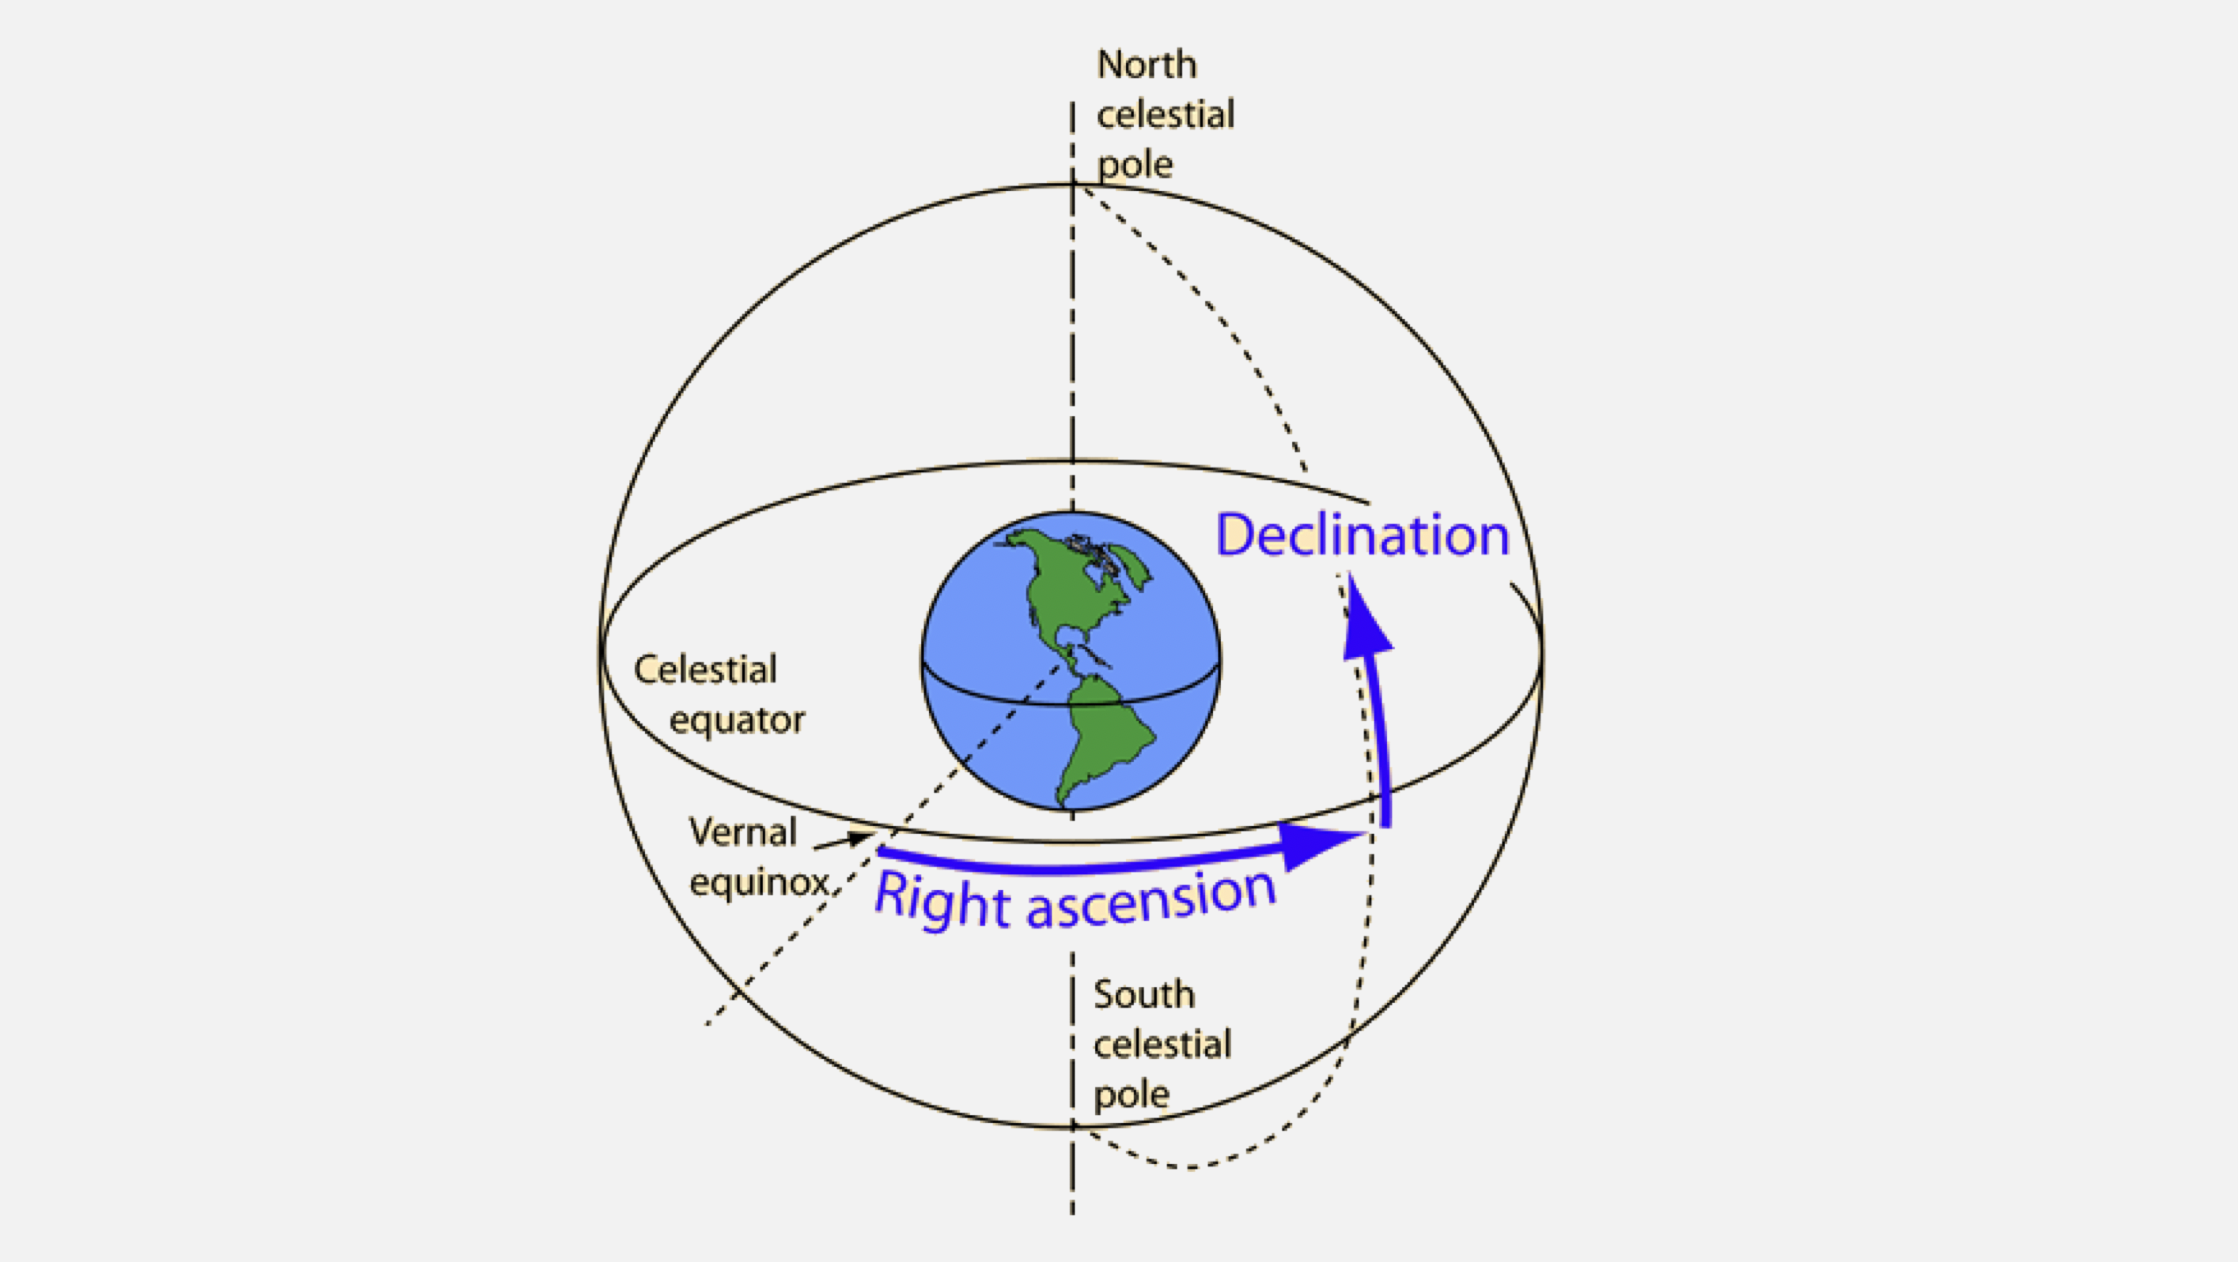

Sources:
- Image: http://hyperphysics.phy-astr.gsu.edu/hbase/eclip.html
- Definitions:https://skyandtelescope.org/astronomy-resources/right-ascension-declination-celestial-coordinates/

#### Filters:

A photomectric system is a set of optical filters with known sensitivity to specific wave lengths of the electromagnetic spectrum. When each filter is used, it is able to measure the intensity of light being emited in the filter's range. The data contains measurements from 5 different filters.
- u: UV filter
- g: green filter
- r: red filter
- i: near infrared filter
- z: inframred filter

Source: https://en.wikipedia.org/wiki/Photometric_system

#### Redshift:

'Red shift' occurs when a wavelength of the light is stretched, so the light is seen as 'shifted' towards the red part of the spectrum, similar to the doppler effect. As objects move away from us through space (due to teh expansion of the universe), the shift in the wavelenght can be measured and the relative motion of the object can be determined.


"The red shift of a distant galaxy or quasar is easily measured by comparing its spectrum with a reference laboratory spectrum. Atomic emission and absorption lines occur at well-known wavelengths. By measuring the location of these lines in astronomical spectra, astronomers can determine the red shift of the receding sources."

Source: https://www.esa.int/Science_Exploration/Space_Science/What_is_red_shift




## Import Packages

In [ ]:
# scikeras does not come installed in Google Collab. Install it here.
! pip install scikeras[tensorflow]

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
# import statsmodels.api as sm
import json

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelBinarizer
from sklearn.metrics import f1_score, mean_squared_error, r2_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from imblearn.over_sampling import SMOTE

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense
from keras.models import Sequential
from keras import regularizers

from scikeras.wrappers import KerasClassifier


# from surprise import Reader, Dataset
# from surprise.model_selection import cross_validate, GridSearchCV
# from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline
# from surprise.model_selection import train_test_split
# from surprise import accuracy

## Import Data

Import the data from the drive

In [4]:
# import the star classification data set from it's location on MyDrive
data = pd.read_csv('data/star_classification.csv')

### Explore Data

Display the first 5 rows to see the columns present and the types of values occuring in those columns
- 17 numerical columns
- 1 categorical column

In [5]:
# investigate first 5 rows
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


Show the number of non-null values in each column to get a feel for the amount of data that could be missing.
- There are no null columns present.

In [6]:
# investigate column non-null counts - no nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

Display that stats of each column to see if there are any values that stand out as likely outliers. These could indicate non-sensical numerical values used to fill in missing data.
- there are 3 columns with minimum values at -9999.0, whic are at a much lower number than other similar columns, and are a out of range of the range given through the mean and standard deviation of the column. These are likely missing values replaced with -9999.0
- This also appears to be the only number below 0 for these columns.

In [7]:
# investigate the descriptive statistics of each column
data.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.237665e+18,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,4481.366060,301.0,3.511610,186.130520,5.783882e+18,0.576661,5137.009660,55588.647500,449.312740
std,8.438560e+12,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,1964.764593,0.0,1.586912,149.011073,3.324016e+18,0.730707,2952.303351,1808.484233,272.498404
min,1.237646e+18,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,109.000000,301.0,1.000000,11.000000,2.995191e+17,-0.009971,266.000000,51608.000000,1.000000
25%,1.237659e+18,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,3187.000000,301.0,2.000000,82.000000,2.844138e+18,0.054517,2526.000000,54234.000000,221.000000
50%,1.237663e+18,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,4188.000000,301.0,4.000000,146.000000,5.614883e+18,0.424173,4987.000000,55868.500000,433.000000
75%,1.237668e+18,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,5326.000000,301.0,5.000000,241.000000,8.332144e+18,0.704154,7400.250000,56777.000000,645.000000
max,1.237681e+18,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,8162.000000,301.0,6.000000,989.000000,1.412694e+19,7.011245,12547.000000,58932.000000,1000.000000


## Data Cleaning

Remove the values with values below 0. This results in only 1 row being excluded from the analysis.

In [5]:
# -9999.0 (the minimum for u, g, and z) is an outlier, likely used as a place holder for missing values.
# Remove rows with these values (only 1 row)
data = data[data['u'] > 0]
data = data[data['g'] > 0]
data = data[data['z'] > 0]
len(data)

99999

Count the number of occurances for each class in the class column (the only categorical column in the dataset)
- there is an inbalance within the class counts. The GALAXY class owns a little more than half of the rows, with the rest split between the STAR classes.

In [6]:
# get the counts for each class
data['class'].value_counts()

class
GALAXY    59445
STAR      21593
QSO       18961
Name: count, dtype: int64

Remove columns that are not relevant.
- remove:
  - run_ID: unique idnetifier for each run
  - obj_ID: unique identifier for each object
  - spec_obj_ID: unique identifer assigned based on class
  - MJD: date the observation was made

In [7]:
# separate the id column and target column
id_column = 'obj_ID'
target_column = 'class'

ids = data[id_column]

# remove unnecessary columns
drop_cols = ['obj_ID', 'run_ID', 'spec_obj_ID', 'MJD']
relevant_columns = data.drop(columns=drop_cols)

# separate the class column from the feature columns
classes = relevant_columns[target_column]
feature_columns = relevant_columns.drop(columns=target_column, axis=1)

## Total Dataset Visualizations

### Create objects of data for each individual class

In [8]:
galaxies = stars = relevant_columns[relevant_columns['class'] == 'GALAXY']
quasars = relevant_columns[relevant_columns['class'] == 'QSO']
stars = relevant_columns[relevant_columns['class'] == 'STAR']

### Relative quantities of classes

Visualize the distribution of classes within the dataset

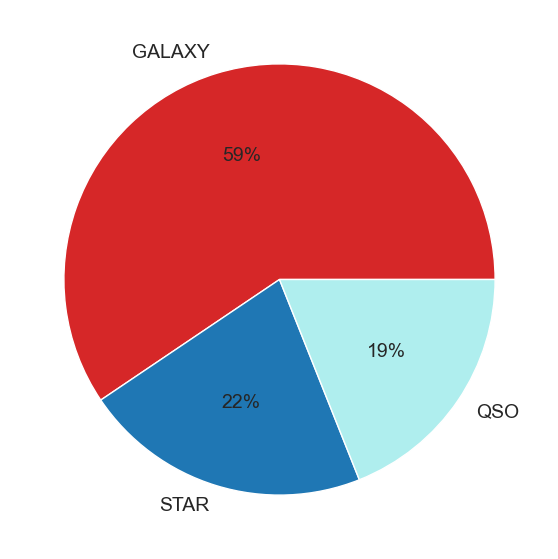

In [9]:
# declaring data
values = list(relevant_columns['class'].value_counts().values)
keys = list(relevant_columns['class'].value_counts().keys())
colors = ['tab:red', 'tab:blue', 'paleturquoise']

# declaring exploding pie
# define Seaborn color palette to use
palette_color = sns.color_palette('dark')
sns.set_style("whitegrid")
plt.figure(figsize=(7,7))
plt.rc('font', size=14)
# plotting data on chart
plt.pie(values, labels=keys, colors=colors, autopct='%.0f%%')

# displaying chart
plt.show()

The majority of objects observed were galaxies, with the remaining observations split roughly evenly between star and QSO. This may lead to a class imbalace and can be addressed using synthetic oversampling

### Object location in the **sky**

Use the alpha and delta columns to map the location of each object in the sky
- alpha: right ascension angle (at J2000 epoch)
- delta: declination angle (at J2000 epoch)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(11,11))
ax.plot(galaxies.alpha.values, galaxies.delta.values, 'b.')
ax.plot(stars.alpha.values, stars.delta.values, 'r.')
ax.plot(quasars.alpha.values, quasars.delta.values, 'g.')
# ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

ax.set_title("Classifications", va='bottom')
plt.show()

The sky is dense with objects, with density remaining fairly constent throughout the sky. Observations only start to thin out around the edges.

Color legend:
- blue: galaxies
- red: stars
- green: quasars

#### Plot the object locations for each class separately

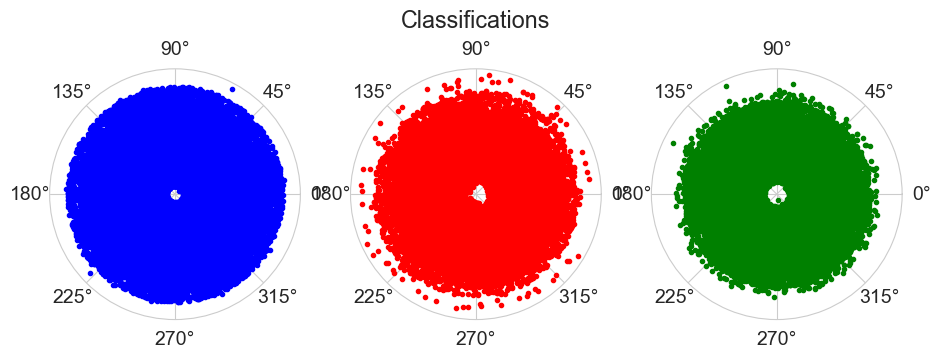

In [12]:
import matplotlib.pyplot as plt
import numpy as np

delta_stars = data[data['class'] == 'STAR'].delta.values
alpha_stars = data[data['class'] == 'STAR'].alpha.values

delta_galaxy = data[data['class'] == 'GALAXY'].delta.values
alpha_galaxy = data[data['class'] == 'GALAXY'].alpha.values

delta_qso = data[data['class'] == 'QSO'].delta.values
alpha_qso = data[data['class'] == 'QSO'].alpha.values

fig, ax = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(11,11))
ax[0].plot(alpha_galaxy, delta_galaxy, 'b.')
ax[0].set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax[0].set_rlabel_position(-22.5)  # Move radial labels away from plotted line

ax[1].plot(alpha_stars, delta_stars, 'r.')
ax[1].set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax[1].set_rlabel_position(-22.5)  # Move radial labels away from plotted line

ax[2].plot(alpha_qso, delta_qso, 'g.')
ax[2].set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax[2].set_rlabel_position(-22.5)  # Move radial labels away from plotted line
# ax.grid(True)

ax[1].set_title("Classifications", va='bottom')
plt.show()

### Redshift

#### Plot the redshift for each object against it's declination angle.

- It doesn't indidate a correlation between the two variables, however it demonstrates the gradient of separation between classes as redshift increases.
- There appears to be clear upper limits for redshift for each class
- Some overlap between the classes in the lower redshift values.

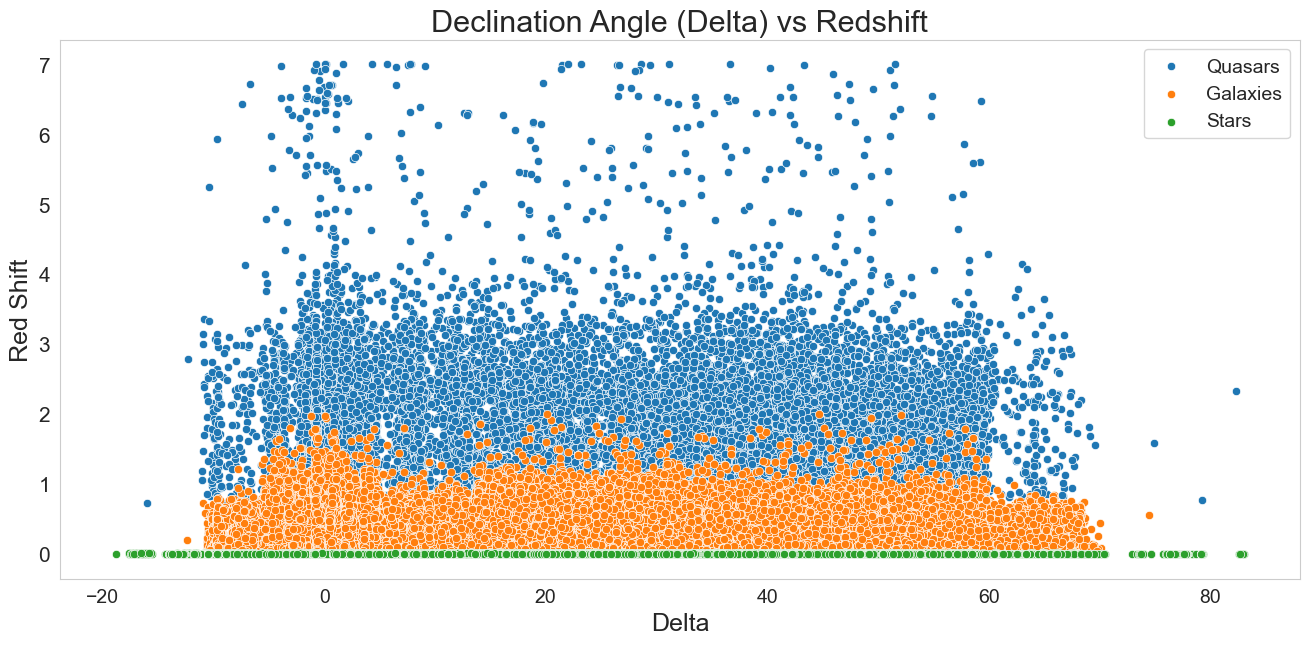

In [13]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=quasars, x='delta', y='redshift', label='Quasars')
sns.scatterplot(data=galaxies, x='delta', y='redshift', label='Galaxies')
sns.scatterplot(data=stars, x='delta', y='redshift', label='Stars')
plt.legend()
plt.yticks(fontsize=15)
plt.xlabel('Delta', fontsize=18)
plt.ylabel('Red Shift', fontsize=18)
plt.title('Declination Angle (Delta) vs Redshift', fontsize=22)
plt.grid()

# maybe plot standard deviation?
# feed this scatter plot into a large language model to see how they would describe the pattern

Quassars experience the most redshift, followed by galaxies. Stars show very little redshift, as the stars we can observe are in our own galaxy.

#### Plot the redshift for each object agains it's UV filter value


- Indidates a small correlation between the two variables.
- There again appears to be clear upper limits for redshift for each class
- Some overlap between the classes in the lower redshift values.

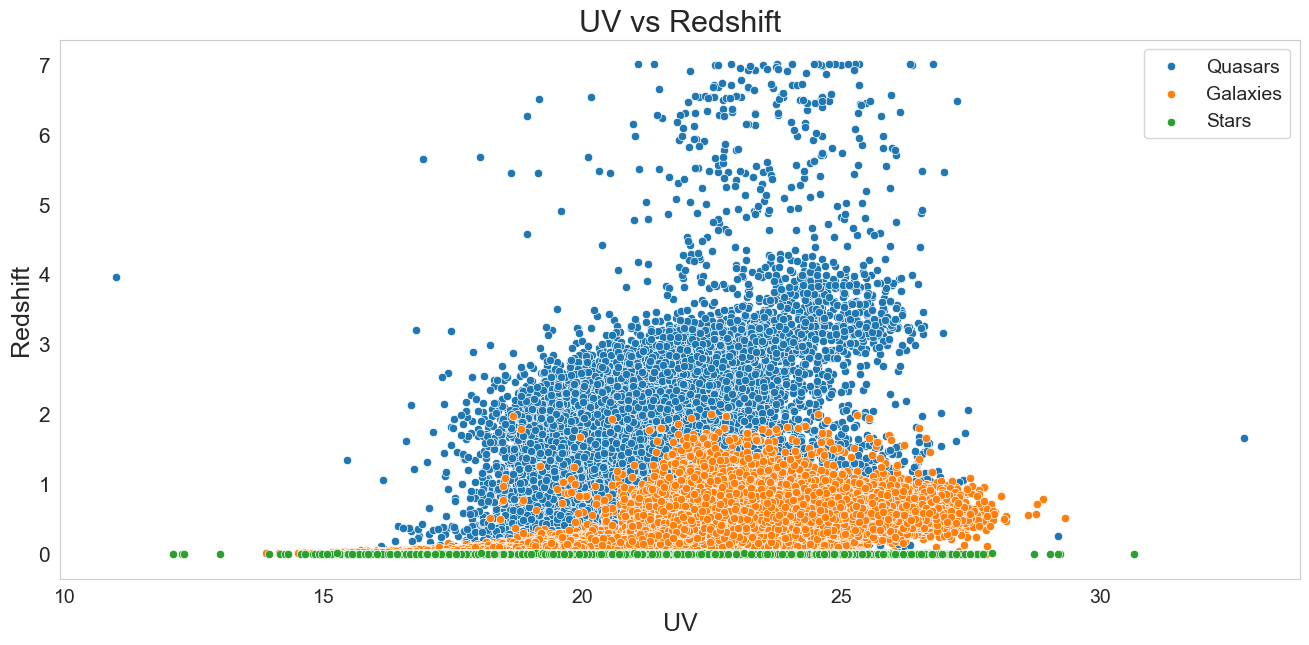

In [14]:
plt.figure(figsize=(16,7))
sns.scatterplot(data=quasars, x='u', y='redshift', label='Quasars')
sns.scatterplot(data=galaxies, x='u', y='redshift', label='Galaxies')
sns.scatterplot(data=stars, x='u', y='redshift', label='Stars')
plt.legend()
plt.yticks(fontsize=15)
plt.xlabel('UV', fontsize=18)
plt.ylabel('Redshift', fontsize=18)
plt.title('UV vs Redshift', fontsize=22)
plt.grid()

# Modeling

## Prep data

#### Normalize the data to a standard scale

In [15]:
# Normalize the data using a standard scaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(feature_columns)
scaled_data

array([[-0.43459711,  0.42551735,  0.79879842, ...,  0.07954924,
         0.22862603, -1.02135336],
       [-0.33991532,  0.36339074,  1.19806416, ...,  0.27708778,
         1.79791221, -0.08189309],
       [-0.36724437,  0.58270185,  1.41373172, ...,  0.09241476,
        -0.19003093, -0.55162323],
       ...,
       [ 0.48660848, -0.42937416, -0.40492933, ..., -0.59299029,
        -0.80379017, -1.37732072],
       [ 0.35895548,  1.14662131,  1.45252238, ..., -0.16645154,
         0.54668338,  0.07590687],
       [ 0.19965777,  1.28937252,  0.24034526, ..., -0.04615046,
         0.76989935,  1.47408797]])

#### Split the data into 4 different train and test data sets
1. Full data set split into test / train
2. Smaller (half size) data set split into test / train to make development faster
3. Full data set resampled to deal with the unequal class distribution
4. Smaller data set resampled to deal with the unequal class distribution

In [12]:
# 1. Full trian and test dataset
X = scaled_data
y = classes
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [13]:
# 2. Smaller train and test dataset for development
X_half, _, y_half, _ = train_test_split(X, y, test_size=0.5, random_state=SEED)
X_train_dev, X_test_dev, y_train_dev, y_test_dev = train_test_split(X_half, y_half, test_size=0.3, random_state=SEED)

Resample the data set and small dataset

In [14]:
# 3. Resampled full trian and test dataset
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [15]:
# 4. Resampled smaller train and test dataset for development
smote = SMOTE()
X_train_resampled_dev, y_train_resampled_dev = smote.fit_resample(X_train_dev, y_train_dev)

Select the data to use to train the models

In [16]:
# select the data set to use
X_train = X_train_resampled
X_test = X_test
y_train = y_train_resampled
y_test = y_test

## Metric Selection and Functions



The success of the model will lie in it's ability to accurately assign a class to an object. While neither false positives or false negatives are desirable, neither outweighs the other. A metric that accounts for both equally should be used as the primary success metric.

### Accuracy:
takes into account both false positives and false negatives by dividing the number of correctly identified observations by the total number of observations

### Function to generate a confusion matrix given the true and predicted y values

In [20]:
def generate_confusion_matrix(y_test, y_hat):
  """
  Function to create and dispaly a confusin matrix

  args:
    - y_test: true values of y
    - y_hat: predicted values of y
  """
  cnf_matrix = confusion_matrix(y_test, y_hat)
  disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['GALAXY', 'QSO', 'STAR'])
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

### Function to convert encoded results back into class strings

In [19]:
def condense_results(y_results):
  y_classes = []
  for y in y_results:
    y = list(y)
    max_loc = y.index(max(y))
    if max_loc == 0:
      y_class = 'GALAXY'
    elif max_loc == 1:
      y_class = 'QSO'
    else:
      y_class = 'STAR'
    y_classes.append(y_class)
  return y_classes

## Base Model: Decision Tree

The inital model used to develop a baseline of performance is a simple decision tree.

In [17]:
# set the parameters for the initial decision tree
criterion='gini'
SEED=42

# intialize and fit the tree
clf_base = DecisionTreeClassifier(criterion=criterion, random_state=SEED)
clf_base.fit(X_train, y_train)

# predict
y_tree = clf_base.predict(X_test)

# classification report
final_report = classification_report(y_test, y_tree)
print(final_report)

              precision    recall  f1-score   support

      GALAXY       0.97      0.95      0.96     17816
         QSO       0.87      0.93      0.90      5742
        STAR       0.99      1.00      1.00      6442

    accuracy                           0.96     30000
   macro avg       0.95      0.96      0.95     30000
weighted avg       0.96      0.96      0.96     30000



Interpretation: The decision tree was able to obtain 96% accuracy, indicating a well defined dataset that is relatively simple to differentiate. Several more complicated models will be tested to see if there is any improvement that can be made.

#### Confusion Matrix

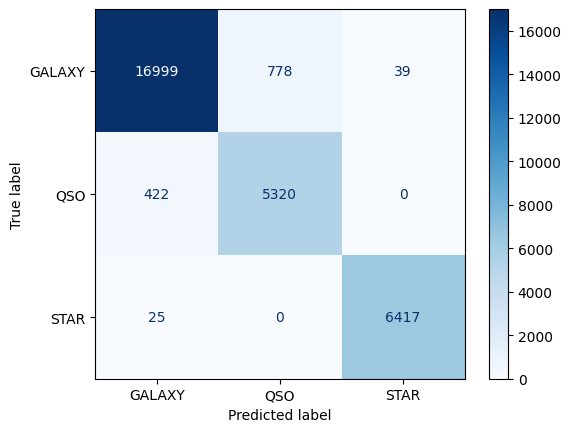

In [21]:
generate_confusion_matrix(y_test, y_tree)

Interpretation: The model is very good at differentiating stars from Quasars, decent at differentiating stars from galaxies, and okay at differentiating galaxies from quasars.

## Neural Net Prep

### Class prep
Encode the class column to separate it out into three numerical columns, one for each class.

In [22]:
# function to perform one hot encoding on the y results
def create_y_ohe(y, columns):
    """
    function to encode a given y data set
        Inputs:
            - y: dataframe to encode
            - columns: list of column names included in the encoding
        Outputs:
            - y_ohe_df: final encoded dataframe
    """
    # initialize the encoder
    ohe = OneHotEncoder()

    # create a y dataframe
    y_df = pd.DataFrame(y, columns=columns)

    # encode the dataframe
    y_ohe = ohe.fit_transform(y_df).toarray()

    # converte the encoded y back into a dataframe
    y_ohe_df = pd.DataFrame(y_ohe, columns=ohe.get_feature_names_out(y_df.columns))

    return y_ohe_df

#### Encode the train and test class columns

In [23]:
# change target class to be numerical
y_train_encoded = create_y_ohe(y_train.values, ['Class'])
y_test_encoded = create_y_ohe(y_test.values, ['Class'])

### Functions to Build and Run a Neural Net

#### Build a Neural Net

In [56]:
# define universal neural net and cross validation parameters
n_features_ = len(feature_columns.columns)
n_folds = 5

In [25]:
def build_neural_net(n_layers, n_features, layer_activation='relu', output_activation='softmax',
                             loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'],
                             l2_reg=False):
  """
  function to build a neural net, provided certain parameters

  Args:
    - n_layers: the nubmer of hidden layers to add
    - n_features: the number of features in the input data
    - layer_activation: function to use to activate each layer
    - output_activation: function to activate the output layer
    - loss: loss function
    - optimizer: the optimizer
    - metrics: the metrics to output
    - l2_reg: boolean, whether or not to include L2 regularization

  Returns:
    - nn: neural net object
  """

  nn = Sequential()
  # one layer
  nn.add(Dense(n_features, activation='tanh', input_shape=(n_features,)))

  for layer in range(0, n_layers-1):

    if l2_reg:
      nn.add(Dense(6, kernel_regularizer=regularizers.l2(0.05), activation=layer_activation))
    else:
      nn.add(Dense(6, activation=layer_activation))

  # output layer
  nn.add(Dense(3, activation=output_activation))
  nn.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  return nn

#### Run a Neural Net

Create a function that can build and run a neural net when given the input parameters to define the neural net.

In [26]:
def build_and_run_neural_net(n_layers, n_features, layer_activation='relu', output_activation='softmax',
                             loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'],
                             n_epochs=8, batch_size=21, validation_split=0.2):
  """
  build and run a neural net based on the parameters given

  Args:
    - n_layers: the number of layers
    - n_features: the number of features included in the dataset
    - layer_activation: the activation function to use for the layers
    - output_activation: the activation function used for the output layer
    - loss: the loss function used
    - optimizer: the optimizer used
    - metrics: the metrics to record performance of the neural net
    - n_epochs: the number of epochs to run the neural net through
    - batch_size: the number of data samples to include in each pass over of the data
    - validation_split: the fraction of samples to reserve for validation

  Returns:
    - nn: the built out nerual net object
    - nn_results: the results of the neural net
  """

  # call the build nerual net function
  nn = build_neural_net(n_layers, n_features, layer_activation=layer_activation,
                            output_activation=output_activation, loss=loss,
                            optimizer=optimizer, metrics=metrics,
                            l2_reg=False)

  # employ early stopping to fight overfitting
  early_stopping = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath=f'best_model_nn_{n_layers}.h5', monitor='val_loss', save_best_only=True)]

  # get results
  results_nn = nn.fit(X_train, y_train_encoded, epochs=n_epochs, batch_size=batch_size,
                      validation_split=validation_split, callbacks=early_stopping)

  # evaluate
  results_test = nn.evaluate(X_test, y_test_encoded)

  return nn, results_nn

## Single Layer Neural Net

Create and run the simplest version of a neural net, a single layer neural net

In [27]:
# call the build and run nerual net function to run and fit the nerual net
nn_1, nn_1_results = build_and_run_neural_net(n_layers=1, n_features=n_features_, n_epochs=15)

Epoch 1/15
4758/4758 [==============================] - 11s 2ms/step - loss: 0.3787 - acc: 0.8658 - val_loss: 0.3768 - val_acc: 0.9087
Epoch 2/15
4758/4758 [==============================] - 11s 2ms/step - loss: 0.2349 - acc: 0.9303 - val_loss: 0.2438 - val_acc: 0.9826
Epoch 3/15
4758/4758 [==============================] - 11s 2ms/step - loss: 0.1989 - acc: 0.9432 - val_loss: 0.2310 - val_acc: 0.9539
Epoch 4/15
4758/4758 [==============================] - 11s 2ms/step - loss: 0.1810 - acc: 0.9466 - val_loss: 0.1572 - val_acc: 0.9940
Epoch 5/15
4758/4758 [==============================] - 9s 2ms/step - loss: 0.1699 - acc: 0.9490 - val_loss: 0.1362 - val_acc: 0.9927
Epoch 6/15
4758/4758 [==============================] - 9s 2ms/step - loss: 0.1625 - acc: 0.9502 - val_loss: 0.1773 - val_acc: 0.9641
Epoch 7/15
4758/4758 [==============================] - 10s 2ms/step - loss: 0.1571 - acc: 0.9516 - val_loss: 0.0888 - val_acc: 0.9981
Epoch 8/15
4758/4758 [==============================] - 8

#### Plot the train and test loss as the epochs increase
The loss seems to flatten gradually, indicating a decrease in benefit for each epoch.

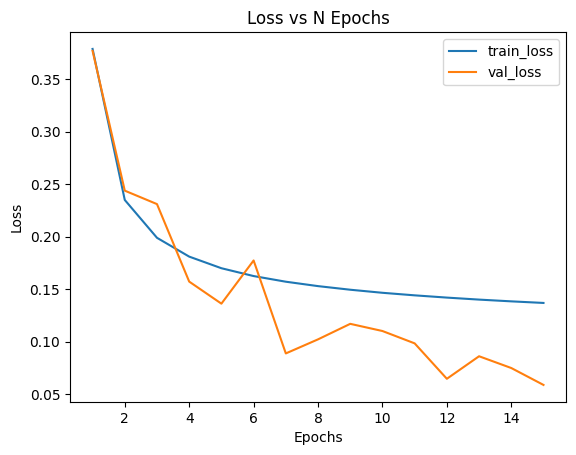

In [60]:
epochs = range(1, len(nn_1_results.history['loss'])+1)
loss = nn_1_results.history['loss']
val_loss = nn_1_results.history['val_loss']

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss vs N Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interpretation: The training loss is able to level out smoothly, while the val loss fluctuates a bit more (due to a smaller amount of data. There is no significant improvement in the model as the epochs increase that doesn't roughly mirror the improvement of the training loss.

Cross-Validate the Model to get an accuracy score

In [29]:
# https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/

estimator = KerasClassifier(build_fn=nn_1, epochs=3, batch_size=21, verbose=0)
kfold = KFold(n_splits=5, shuffle=True)
results_k_nn_1 = cross_val_score(estimator, X_train, y_train_encoded, cv=kfold)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/scikeras

In [30]:
print("Baseline: %.2f%% (%.2f%%)" % (results_k_nn_1.mean()*100, results_k_nn_1.std()*100))

Baseline: 96.40% (0.06%)


Predict the classes of the reserved test set, and create a classification report

In [31]:
# predict
y_nn_1 = nn_1.predict(X_test)

# condense the encoded results back into the categorical format
y_nn_1_classes = condense_results(y_nn_1)

# create a classification report
nn_1_report = classification_report(y_test, y_nn_1_classes)
print(nn_1_report)

938/938 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

      GALAXY       0.98      0.95      0.96     17816
         QSO       0.92      0.93      0.93      5742
        STAR       0.94      1.00      0.97      6442

    accuracy                           0.96     30000
   macro avg       0.95      0.96      0.95     30000
weighted avg       0.96      0.96      0.96     30000



Interpretation: The single layer neural net performed equal to the decision tree, with an accuracy of 96%



#### Confusion Matrix

generate a confusion matrix to investiagte false positives and false negatives

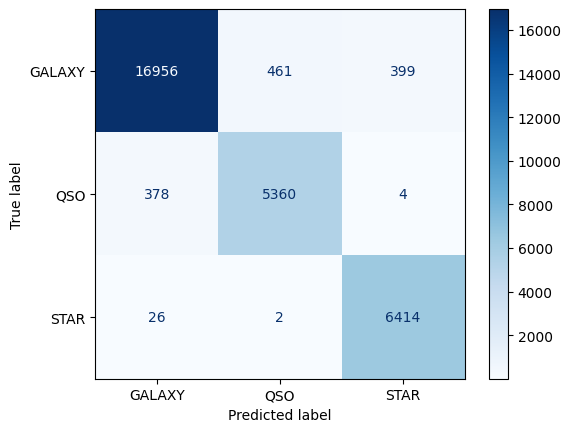

In [32]:
# generate a confusion matrix to investiagte false positives and false negatives
generate_confusion_matrix(y_test, y_nn_1_classes)

Interpretation: The single layer neural net was better at differentiating galaxies from quasars than the deicision tree, at the expense of a few more mis-labeled stars.

## Three Layer Neural Net

Create and run another simple version of a neural net, a three layer neural net

In [39]:
# call the build and run nerual net function to run and fit the nerual net
nn_3, nn_3_results = build_and_run_neural_net(n_layers=3, n_features=n_features_, n_epochs=15)

Epoch 1/15
4758/4758 [==============================] - 12s 2ms/step - loss: 0.4555 - acc: 0.8027 - val_loss: 0.4746 - val_acc: 0.8939
Epoch 2/15
4758/4758 [==============================] - 12s 3ms/step - loss: 0.1839 - acc: 0.9421 - val_loss: 0.1252 - val_acc: 0.9884
Epoch 3/15
4758/4758 [==============================] - 11s 2ms/step - loss: 0.1529 - acc: 0.9493 - val_loss: 0.0597 - val_acc: 0.9973
Epoch 4/15
4758/4758 [==============================] - 10s 2ms/step - loss: 0.1435 - acc: 0.9523 - val_loss: 0.0423 - val_acc: 0.9950
Epoch 5/15
4758/4758 [==============================] - 9s 2ms/step - loss: 0.1389 - acc: 0.9541 - val_loss: 0.0842 - val_acc: 0.9822
Epoch 6/15
4758/4758 [==============================] - 12s 3ms/step - loss: 0.1339 - acc: 0.9556 - val_loss: 0.0447 - val_acc: 0.9956
Epoch 7/15
4758/4758 [==============================] - 12s 3ms/step - loss: 0.1302 - acc: 0.9568 - val_loss: 0.0292 - val_acc: 0.9994
Epoch 8/15
4758/4758 [==============================] - 

Cross-Validate the Model to get an accuracy score

In [ ]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=5),
                  ModelCheckpoint(filepath=f'best_model_nn_3.h5', monitor='val_loss', save_best_only=True)]
estimator = KerasClassifier(build_fn=nn_3, epochs=3, batch_size=21, verbose=0, callbacks=early_stopping)
kfold = KFold(n_splits=5, shuffle=True)
results_k_nn_3 = cross_val_score(estimator, X_train, y_train_encoded, cv=kfold)

In [41]:
print("Baseline: %.2f%% (%.2f%%)" % (results_k_nn_3.mean()*100, results_k_nn_3.std()*100))

Baseline: 96.99% (0.09%)


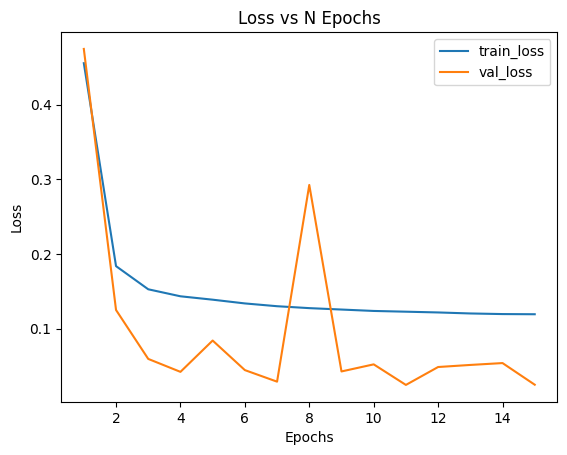

In [61]:
epochs = range(1, len(nn_3_results.history['loss'])+1)
loss = nn_3_results.history['loss']
val_loss = nn_3_results.history['val_loss']

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss vs N Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interpretation: The training loss is still able to level out smoothly, while the val loss fluctuates. The large peak in the middle reparesnts an epoch that was not divided as well. It the quicly retuned to it's normal levels. The val loss is lower than the training loss at a (mostly) consistent rate, showing that there is no significant overfitting.

In [42]:
# predict
y_nn_3 = nn_3.predict(X_test)
y_nn_3_classes = condense_results(y_nn_3)

nn_3_report = classification_report(y_test, y_nn_3_classes)
print(nn_3_report)

938/938 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      GALAXY       0.98      0.95      0.96     17816
         QSO       0.90      0.95      0.93      5742
        STAR       0.95      1.00      0.97      6442

    accuracy                           0.96     30000
   macro avg       0.94      0.96      0.95     30000
weighted avg       0.96      0.96      0.96     30000



In [44]:
print("Baseline: %.2f%% (%.2f%%)" % (results_k_nn_3.mean()*100, results_k_nn_3.std()*100))

Baseline: 96.99% (0.09%)


In [45]:
# predict
y_nn_3 = nn_3.predict(X_test)

# condense the encoded results back into the categorical format
y_nn_3_classes = condense_results(y_nn_3)


# create a classification report
nn_3_report = classification_report(y_test, y_nn_3_classes)
print(nn_3_report)

938/938 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

      GALAXY       0.98      0.95      0.96     17816
         QSO       0.90      0.95      0.93      5742
        STAR       0.95      1.00      0.97      6442

    accuracy                           0.96     30000
   macro avg       0.94      0.96      0.95     30000
weighted avg       0.96      0.96      0.96     30000



Interpretation: The three layer neural net performed equal to the decision tree and single layer network, with an accuracy of 96%.

A grid search should be performed to determine if there is a neural network configuration that can obtain an accuracy score greater than 96%.

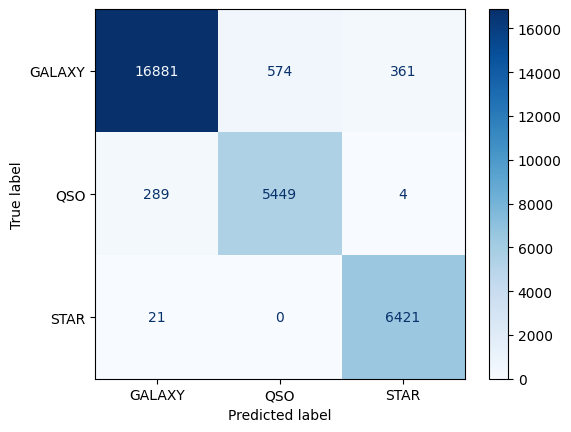

In [58]:
# generate a confusion matrix to compare false positives and false negatives
generate_confusion_matrix(y_test, y_nn_3_classes)

The three layer neural net performed similarly to the single layer neural network, with similar types of false positives and false negatives.

## Grid Search

Employ a grid search to loop through several possible parameters in order to find the set of parameters that results in the most accurate model.

In [54]:
# Ignore TensorFlow Warnings
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709

import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

In [57]:
len(X_train)

124887

Create and run a grid search to identify the optimal paramters.

loop through several activations functions, number of layers, batch sizes, and epochs.
- batch size values were determined by finding factors of the total number of obersvations, 124887
  - total of observations after resampling

In [ ]:
n_layers = [1, 2, 3, 5, 10, 13]
l2_reg = [True, False]
activation_functions = ['relu', 'tanh']
output_activation = 'softmax'
optimizer = 'sgd'
loss = 'categorical_crossentropy'

nn_param_grid = {
    'batch_size':[21, 57],
    'epochs':[15, 10, 5],
}

n_features = len(observation_columns)

for n in n_layers:
  results_list = []
  print(f'n layers = {n}')
  for af in activation_functions:
    print(f'  activation = {af}')
    for l2 in l2_reg:
      print(f'    l2 = {l2}')
      early_stopping = [EarlyStopping(monitor='val_loss', patience=5),
                        ModelCheckpoint(filepath=f'best_model_nn_{n_layers}.h5', save_format="h5", monitor='val_loss', save_best_only=True)]

      # build the nerual net
      nn = build_neural_net(n_layers=n, n_features=n_features, layer_activation=af, l2_reg=l2,
                            optimizer=optimizer, output_activation=output_activation, loss=loss)
      # create the model
      model = KerasClassifier(model=nn, callbacks=early_stopping)

      # run the grid search
      gs=GridSearchCV(estimator=model, param_grid=nn_param_grid, cv=3, verbose=True)

      # fit the dataset to the GridSearchCV object.
      gs = gs.fit(X_train, y_train_encoded)

      # save the best parameters and accuracy
      best_params=gs.best_params_
      accuracy=gs.best_score_
      print(f'     best accuracy = {accuracy}')

      # save results
      results = {
          'n_layers': n,
          'activation_function': af,
          'l2_regularization': l2,
          'best_params': best_params,
          'accuracy': accuracy
      }
      results_list.append(results)

  # add results to the results dict
  results_dict = {
      'results': results_list
  }

  # save the results to the drive in bathces. group by number of layers
  with open(f'drive/MyDrive/Flatiron/Capstone/grid_results_{n}.json', 'w') as f:
    json.dump(results_dict, f)

## Investigate Grid Search Results

Download the grid search results from their location on the google drive. Combine the results and find the most accurate set of parameters.

In [46]:
import json

n_layers = [1, 2, 3, 5, 10, 15]
max_results = []
for n in n_layers:
    with open(f'drive/MyDrive/Flatiron/Capstone/grid_results/grid_results_{n}.json', 'r') as f:
        grid_results = json.load(f)
    for result in grid_results['results']:
        result['n_layers'] = n

    accuracies = list(map(lambda x: x['accuracy'], grid_results['results']))
    max_result = grid_results['results'][accuracies.index(max(accuracies))]
    max_results.append(max_result)

accuracies = list(map(lambda x: x['accuracy'], max_results))
final_max_result = max_results[accuracies.index(max(accuracies))]

In [47]:
final_max_result

{'n_layers': 3,
 'activation_function': 'tanh',
 'l2_regularization': False,
 'best_params': {'batch_size': 21, 'epochs': 20},
 'accuracy': 0.9659051782811662}


# Final NN Model

Use the parameters identified through the grid search to create a final model.

In [64]:
# call the build and run nerual net function to run and fit the nerual net
final_nn, final_nn_results = build_and_run_neural_net(n_layers=3, n_features=n_features_, layer_activation='tanh', n_epochs=20)

Epoch 1/20
4758/4758 [==============================] - 23s 5ms/step - loss: 0.3557 - acc: 0.8692 - val_loss: 0.2375 - val_acc: 0.9390
Epoch 2/20
4758/4758 [==============================] - 23s 5ms/step - loss: 0.1746 - acc: 0.9426 - val_loss: 0.0988 - val_acc: 0.9888
Epoch 3/20
4758/4758 [==============================] - 19s 4ms/step - loss: 0.1515 - acc: 0.9496 - val_loss: 0.0804 - val_acc: 0.9908
Epoch 4/20
4758/4758 [==============================] - 21s 4ms/step - loss: 0.1436 - acc: 0.9524 - val_loss: 0.0481 - val_acc: 0.9964
Epoch 5/20
4758/4758 [==============================] - 13s 3ms/step - loss: 0.1380 - acc: 0.9539 - val_loss: 0.0590 - val_acc: 0.9943
Epoch 6/20
4758/4758 [==============================] - 17s 3ms/step - loss: 0.1361 - acc: 0.9543 - val_loss: 0.1441 - val_acc: 0.9446
Epoch 7/20
4758/4758 [==============================] - 31s 7ms/step - loss: 0.1329 - acc: 0.9560 - val_loss: 0.0585 - val_acc: 0.9899
Epoch 8/20
4758/4758 [==============================] -

Cross-Validate the Model to get an accuracy score

In [ ]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=5),
                        ModelCheckpoint(filepath=f'best_model_nn_final.h5', save_format="h5", monitor='val_loss', save_best_only=True)]

estimator = KerasClassifier(build_fn=final_nn, epochs=20, batch_size=21, callbacks=early_stopping, verbose=0)
kfold = KFold(n_splits=3, shuffle=True)
results_k_nn_final = cross_val_score(estimator, X_train, y_train_encoded, cv=kfold)

In [50]:
print("Baseline: %.2f%% (%.2f%%)" % (results_k_nn_final.mean()*100, results_k_nn_final.std()*100))

Baseline: 96.16% (1.12%)


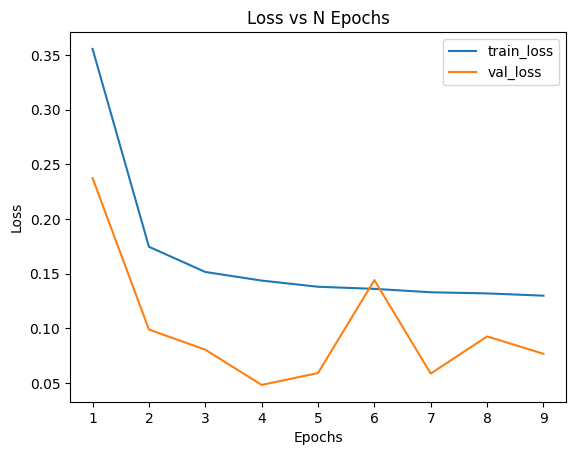

In [69]:
epochs = range(1, len(final_nn_results.history['loss'])+1)
loss = final_nn_results.history['loss']
val_loss = final_nn_results.history['val_loss']

plt.plot(epochs, loss, label='train_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss vs N Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Interpretation: The training loss is still able to level out smoothly, while the val loss fluctuates. The large peak in the middle reparesnts an epoch that was not divided as well. It the quicly retuned to it's normal levels. The val loss is lower than the training loss at a (mostly) consistent rate, showing that there is no significant overfitting.

The model stopped early when the potential to overfit was detected.

Predict the classes of the reserved test set, and create a classification report

In [51]:
# predict
y_final = final_nn.predict(X_test)

# condense the encoded results back into the categorical format
y_final_classes = condense_results(y_final)

# create a classification report
final_report = classification_report(y_test, y_final_classes)
print(final_report)

938/938 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.97     17816
         QSO       0.94      0.94      0.94      5742
        STAR       0.96      0.99      0.98      6442

    accuracy                           0.97     30000
   macro avg       0.96      0.96      0.96     30000
weighted avg       0.97      0.97      0.97     30000



#### Confusion Matrix

generate a confusion matrix to investiagte false positives and false negatives

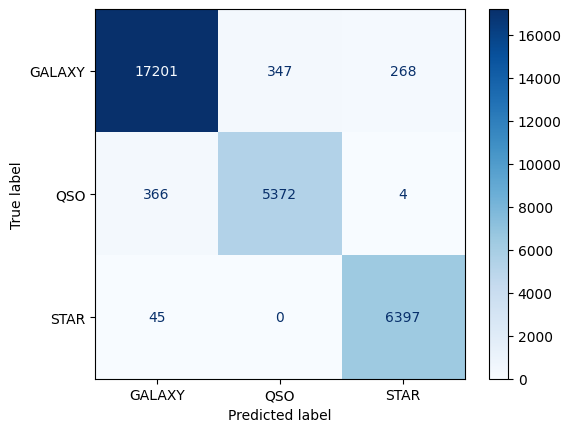

In [53]:
generate_confusion_matrix(y_test, y_final_classes)

We can see that the final model is better at distinguishing galaxies from quasars than be base model, and the expense of a few more galaxies and quasars being mis-identified as stars.

# Conclusion

The final trained as a three layer neural network using normalized and resampled data and optimized using a grid search of parameters. Early Stopping was employed to mitigate overfitting.

Using this final model, we are able to accurately classify objects observed in the night sky with an accuracy of 97%.

# Fin